# Creación de una RED GAN para generar señales sinosuidales de 3 frecuencias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

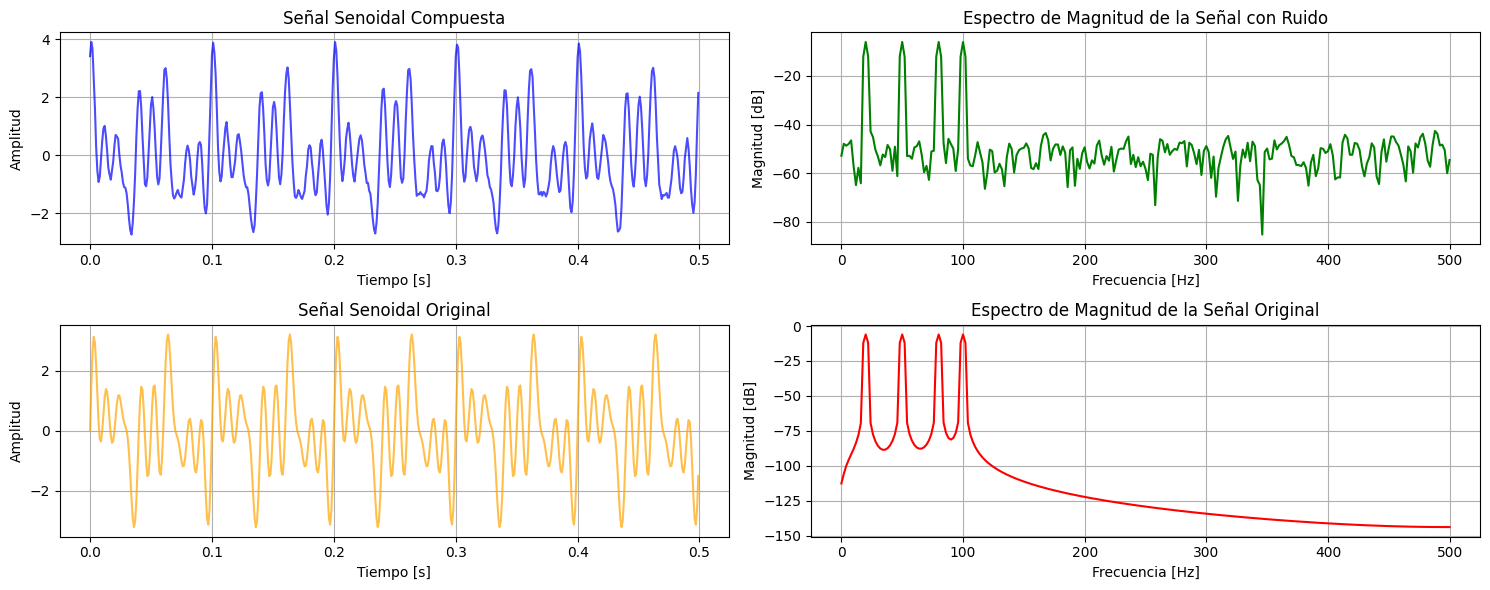

In [2]:
f1 = 20
f2 = 50
f3 = 100
f4 = 80

fs = 1e3
ts = 1/fs
N = 500 #1000
n = np.arange(N)
t = n*ts

noise = np.random.uniform(-0.1, 0.1, N)
phi = np.random.randint(0, 3*np.pi/4)
phi1 = phi
phi2 = phi
phi3 = phi
phi4 = phi

x = np.sin(2*np.pi*f1*n*ts) + np.sin(2*np.pi*f2*n*ts) + np.sin(2*np.pi*f3*n*ts) + np.sin(2*np.pi*f4*n*ts) 
x_noised = np.sin(2*np.pi*f1*n*ts + phi1) + np.sin(2*np.pi*f2*n*ts +phi2) + np.sin(2*np.pi*f3*n*ts + phi3) + np.sin(2*np.pi*f4*n*ts + phi4) + noise

plt.figure(figsize=(15, 6))

plt.subplot(2,2,1)
plt.plot(t, x_noised, label='Señal con Ruido', color='blue', alpha=0.7)
plt.title('Señal Senoidal Compuesta')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()

plt.subplot(2,2,2)
plt.magnitude_spectrum(x_noised, Fs=fs, scale='dB', color='green')
plt.title('Espectro de Magnitud de la Señal con Ruido')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid()

plt.subplot(2,2,3)
plt.plot(t, x, label='Señal Original', color='orange', alpha=0.7)
plt.title('Señal Senoidal Original')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud')
plt.grid()

plt.subplot(2,2,4)
plt.magnitude_spectrum(x, Fs=fs, scale='dB', color='red')
plt.title('Espectro de Magnitud de la Señal Original')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Magnitud [dB]')
plt.grid()

plt.tight_layout()
plt.show()

In [3]:
class Gen_DB_sin():
    def __init__(self, f=[20,50,100, 80], fs=1e3, duration=1.0, noise_std=0.02):
        self.f = f
        self.fs = fs
        self.duration = duration
        self.noise_std = noise_std
        self.ts = 1/fs
        self.n_samples = int(fs * duration)
        self.t = np.arange(self.n_samples) * self.ts

    def generate_single_sample(self):
        f1 = self.f[0]
        f2 = self.f[1]
        f3 = self.f[2]
        f4 = self.f[3]

        fs = 1e3
        ts = 1/fs
        N = self.n_samples
        n = np.arange(N)
        t = self.t #n*ts

        noise = np.random.uniform(-0.1, 0.1, N)
        phi = np.random.randint(0, 3*np.pi/4)
        phi1 = phi
        phi2 = phi
        phi3 = phi
        phi4 = phi

        #x = np.sin(2*np.pi*f1*n*ts) + np.sin(2*np.pi*f2*n*ts) + np.sin(2*np.pi*f3*n*ts) + np.sin(2*np.pi*f4*n*ts) 
        x_noised = np.sin(2*np.pi*f1*n*ts + phi1) + np.sin(2*np.pi*f2*n*ts +phi2) + np.sin(2*np.pi*f3*n*ts + phi3) + np.sin(2*np.pi*f4*n*ts + phi4) + noise
        return x_noised
    
    def generate_dataset(self, n_samples):
        X = []
        for _ in range(n_samples):
            x = self.generate_single_sample()
            X.append(x)
        return np.array(X)

In [4]:
Gen_DB_sin_instance = Gen_DB_sin(f=[20,50,100, 80], fs=1e3, duration=1, noise_std=0.02)
X_dataset = Gen_DB_sin_instance.generate_dataset(n_samples=1000)

X_dataset

array([[-0.03568606,  1.58392751,  2.6905997 , ..., -3.12831519,
        -2.63979562, -1.4480449 ],
       [ 3.28296804,  3.92060403,  3.53783825, ..., -0.6454512 ,
         0.83469028,  2.1967738 ],
       [ 3.28941935,  3.83683116,  3.62577195, ..., -0.58008197,
         0.72916481,  2.29429549],
       ...,
       [ 0.03317719,  1.57836187,  2.71279191, ..., -3.05588084,
        -2.67046806, -1.49113928],
       [ 3.39974307,  3.92248907,  3.58524588, ..., -0.52822788,
         0.79009064,  2.16279306],
       [ 3.42743124,  3.9370154 ,  3.6479406 , ..., -0.68639698,
         0.77567978,  2.23605069]])

In [5]:
X_dataset.shape

(1000, 1000)

## Normalización de datos al rango [-1, 1]

In [6]:
# Normalizar al rango [-1, 1] para coincidir con Tanh
X_min = X_dataset.min()
X_max = X_dataset.max()
X_dataset_normalized = 2 * (X_dataset - X_min) / (X_max - X_min) - 1

print(f"Original range: [{X_min:.3f}, {X_max:.3f}]")
print(f"Normalized range: [{X_dataset_normalized.min():.3f}, {X_dataset_normalized.max():.3f}]")

Original range: [-3.306, 3.966]
Normalized range: [-1.000, 1.000]


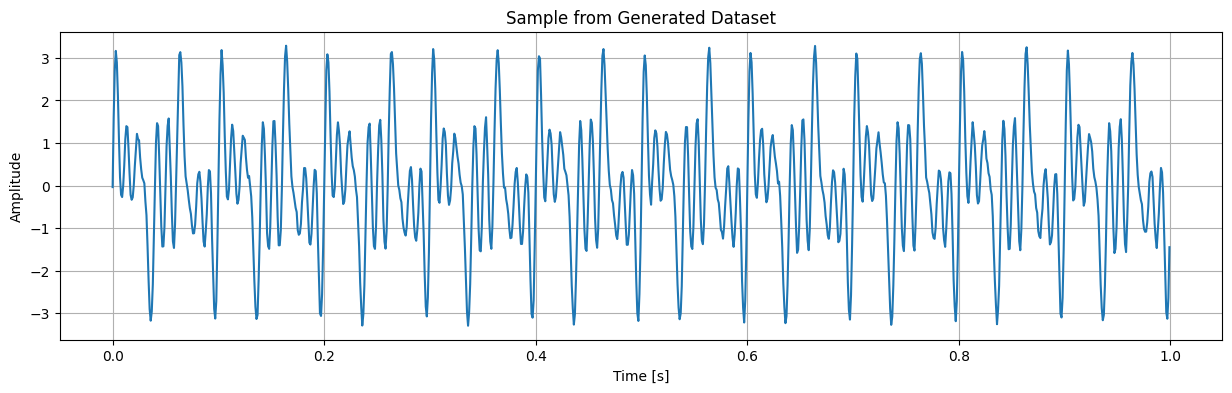

In [7]:
plt.figure(figsize=(15, 4))
plt.plot(Gen_DB_sin_instance.t, X_dataset[0,:])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Sample from Generated Dataset')
plt.grid()
plt.show()

## Dataloader en batch del dataset  de las señales

In [8]:
import torch
import torch.nn as nn
from torch.optim import Adam, AdamW
from torch.utils.data import DataLoader, Dataset

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
seed = 2025
torch.manual_seed(seed)
np.random.seed(seed)

class SineWaveDataset:
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx]
    

def get_dataloader(data, batch_size=32, shuffle=True):
    dataset = SineWaveDataset(data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataloader


batch_size = 32
dataloader = get_dataloader(X_dataset, batch_size=batch_size, shuffle=True)




## Creación del GAN

### Problemas identificados:

Falta normalización de datos: Tu X_dataset no está normalizado al rango [-1, 1], pero el generador usa Tanh() que produce valores en ese rango
Arquitectura pequeña: Para señales con 4 frecuencias, necesitas más capacidad
No hay label smoothing: Puede causar inestabilidad
Falta inicialización de pesos: Importante para convergencia
Pocas épocas: 1000 épocas pueden ser insuficientes

Mejoras implementadas ✅
He mejorado tu GAN con los siguientes cambios críticos:

1. Normalización de datos [-1, 1]
Los datos ahora coinciden con la salida Tanh() del generador
Esto es esencial para que el GAN converja
2. Arquitectura mejorada
Generator: Más capas (256→512→1024→1024→output) con BatchNorm y Dropout
Discriminator: Más profundo (1024→512→256→1) con Dropout
Inicialización de pesos: Según estándar DCGAN (~N(0, 0.02))
3. Técnicas de estabilización
Label smoothing: Real labels = 0.9 (no 1.0) para evitar overconfidence
n_critic=3: Entrena el discriminador 3 veces por cada actualización del generador
Learning rates diferenciados: G=0.0001, D=0.0002
Dropout 0.3: Regularización para evitar overfitting
4. Entrenamiento mejorado
3000 épocas (antes 1000)
Visualización mejorada: Compara señal generada vs real
Desnormalización: Para comparar correctamente con datos originales
5. Métricas de evaluación
Comparación FFT: Verifica que las frecuencias (20, 50, 80, 100 Hz) aparezcan
MSE, MAE, Correlación: Métricas cuantitativas
Spectral MSE: Error en el dominio de frecuencia
📊 Cómo usar:
Ejecuta las celdas de normalización primero
Entrena el modelo (tomará más tiempo pero dará mejores resultados)
Usa la comparación FFT para verificar que se generan las 4 frecuencias correctamente
Revisa las métricas para cuantificar la mejora
🎯 Qué esperar:
En las primeras 500 épocas: ruido → patrones básicos
Épocas 500-1500: aparecen frecuencias dominantes
Épocas 1500-3000: refinamiento y estabilización
La FFT debería mostrar picos claros en 20, 50, 80 y 100 Hz

In [9]:
# Mejorado: Inicialización de pesos + Arquitectura más profunda
def weights_init(m):
    """Inicialización de pesos según DCGAN"""
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        if m.bias is not None:
            nn.init.constant_(m.bias.data, 0)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Generator mejorado (más capas, mejor regularización)
class Generator(nn.Module):
    def __init__(self, noise_dim=128, output_dim=200):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256), 
            nn.BatchNorm1d(256), 
            nn.LeakyReLU(0.2, True),
            
            nn.Linear(256, 512), 
            nn.BatchNorm1d(512), 
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 1024), 
            nn.BatchNorm1d(1024), 
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 1024), 
            nn.BatchNorm1d(1024), 
            nn.LeakyReLU(0.2, True),
            
            nn.Linear(1024, output_dim),
            nn.Tanh()  # Salida en [-1, 1]
        )
        
    def forward(self, z): 
        return self.model(z)

# Discriminator mejorado (más capaz, sin BatchNorm)
class Discriminator(nn.Module):
    def __init__(self, input_dim=200):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 1024), 
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3),
            
            nn.Linear(1024, 512), 
            nn.LeakyReLU(0.2, True),
            nn.Dropout(0.3),
            
            nn.Linear(512, 256), 
            nn.LeakyReLU(0.2, True),
            
            nn.Linear(256, 1)  # logits para BCEWithLogitsLoss
        )
        
    def forward(self, x): 
        return self.model(x.view(x.size(0), -1))

Epoch [50/1000], D Loss: 0.6560, G Loss: 0.0000
Epoch [100/1000], D Loss: 1.2162, G Loss: 0.0000
Epoch [100/1000], D Loss: 1.2162, G Loss: 0.0000


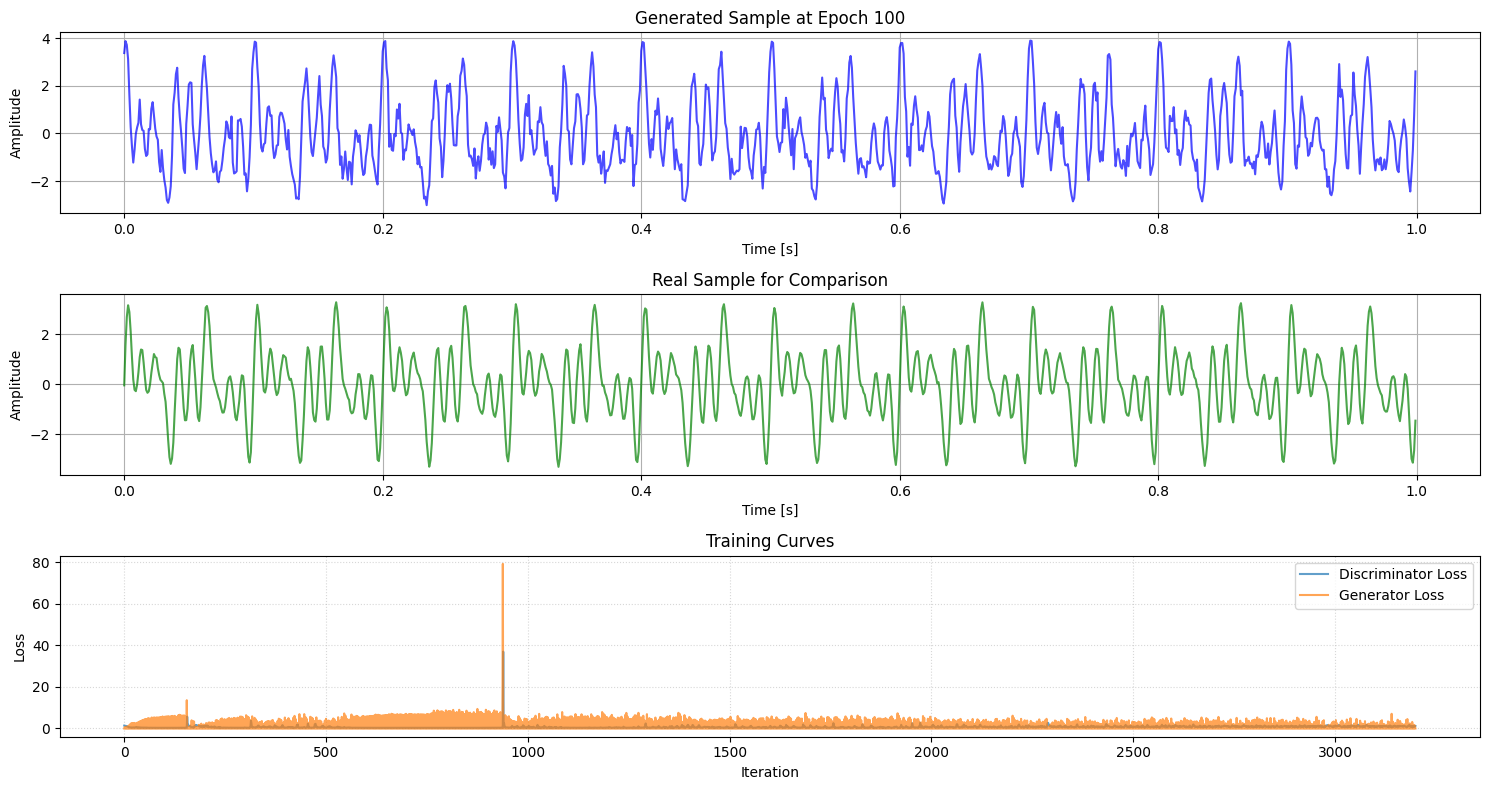

Epoch [150/1000], D Loss: 0.6457, G Loss: 5.8035
Epoch [200/1000], D Loss: 1.3614, G Loss: 0.0000
Epoch [200/1000], D Loss: 1.3614, G Loss: 0.0000


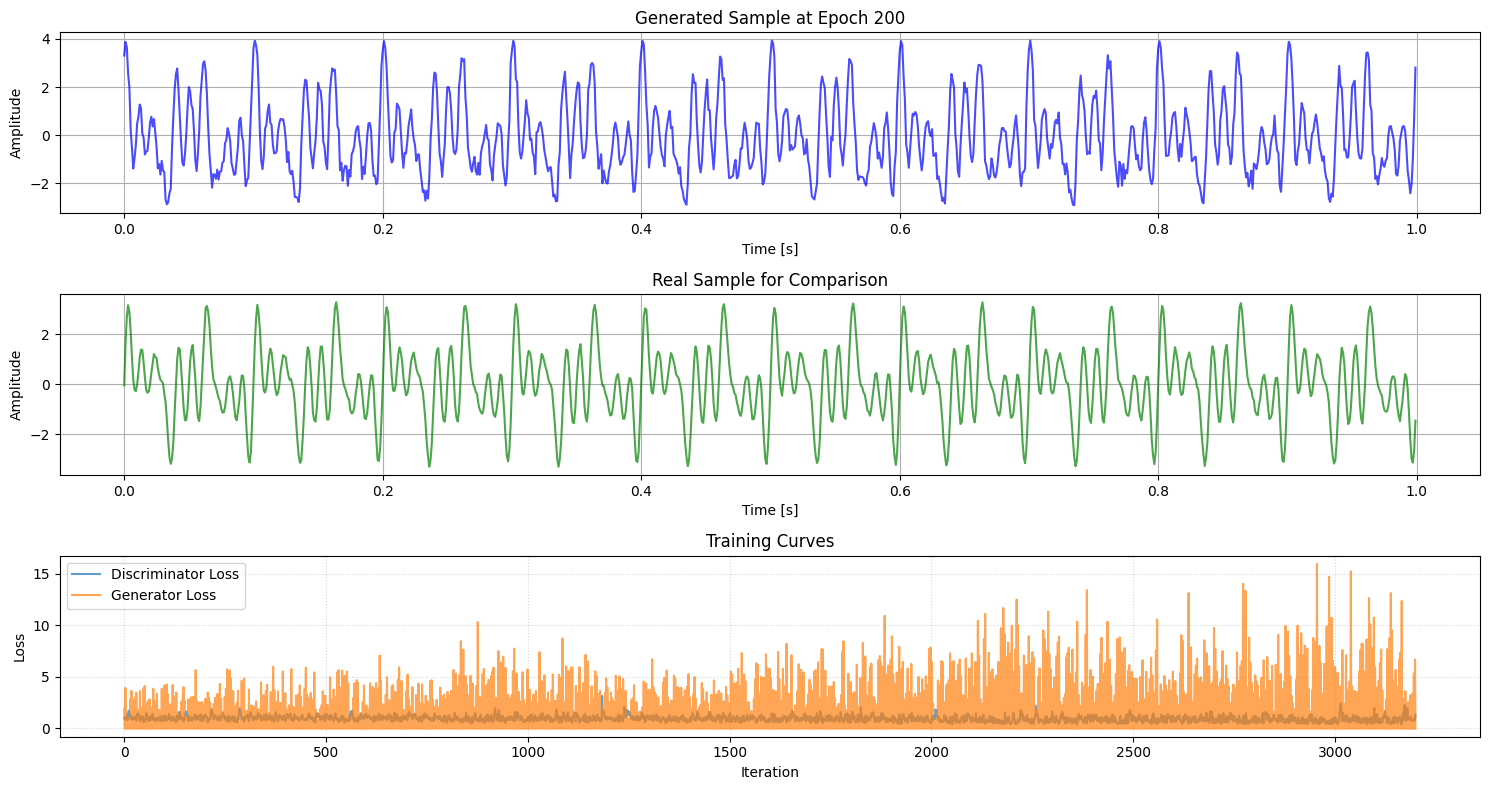

Epoch [250/1000], D Loss: 0.5275, G Loss: 0.0000
Epoch [300/1000], D Loss: 0.5310, G Loss: 4.9637
Epoch [300/1000], D Loss: 0.5310, G Loss: 4.9637


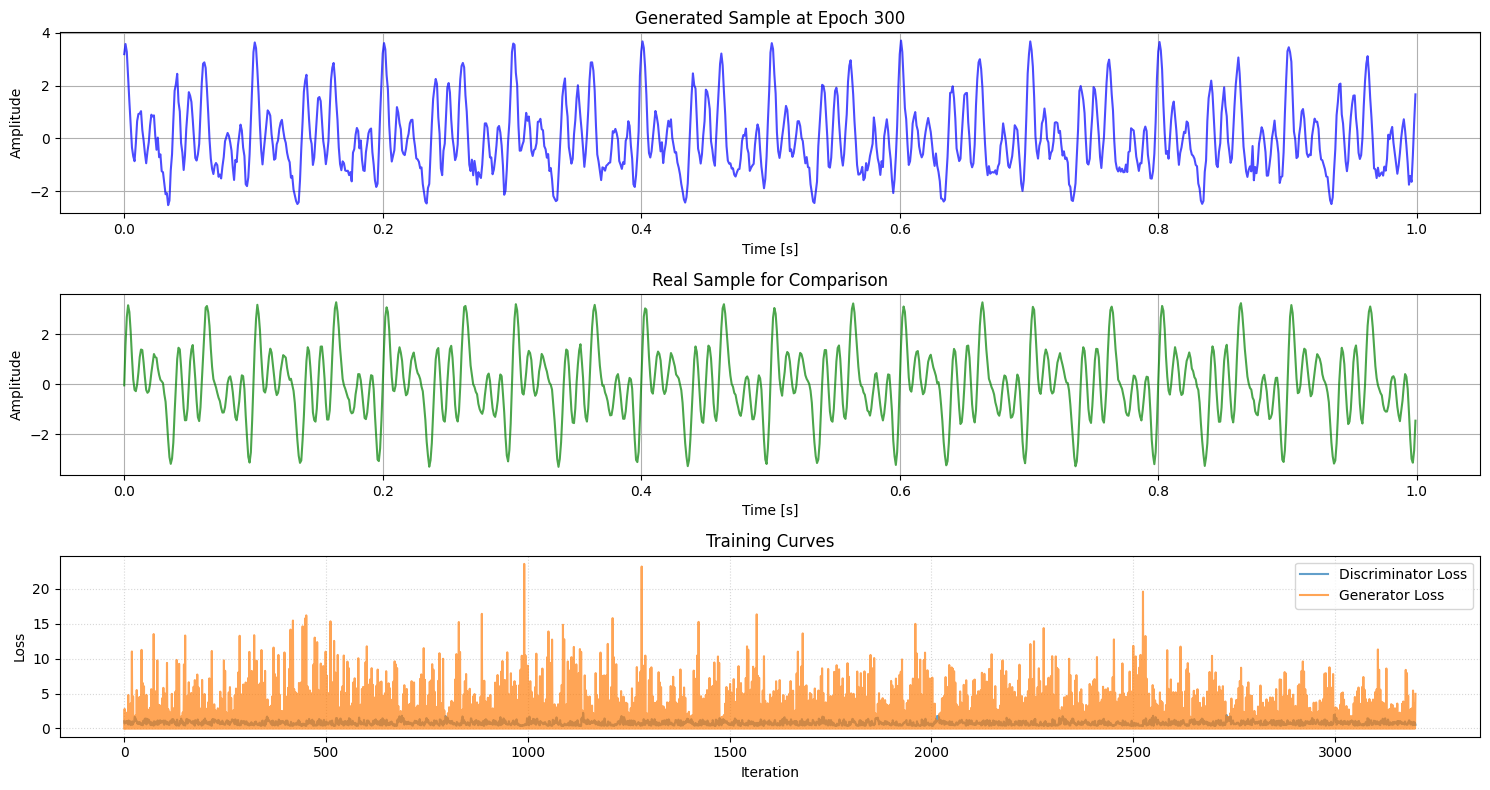

Epoch [350/1000], D Loss: 0.5691, G Loss: 0.0000
Epoch [400/1000], D Loss: 0.3723, G Loss: 0.0000
Epoch [400/1000], D Loss: 0.3723, G Loss: 0.0000


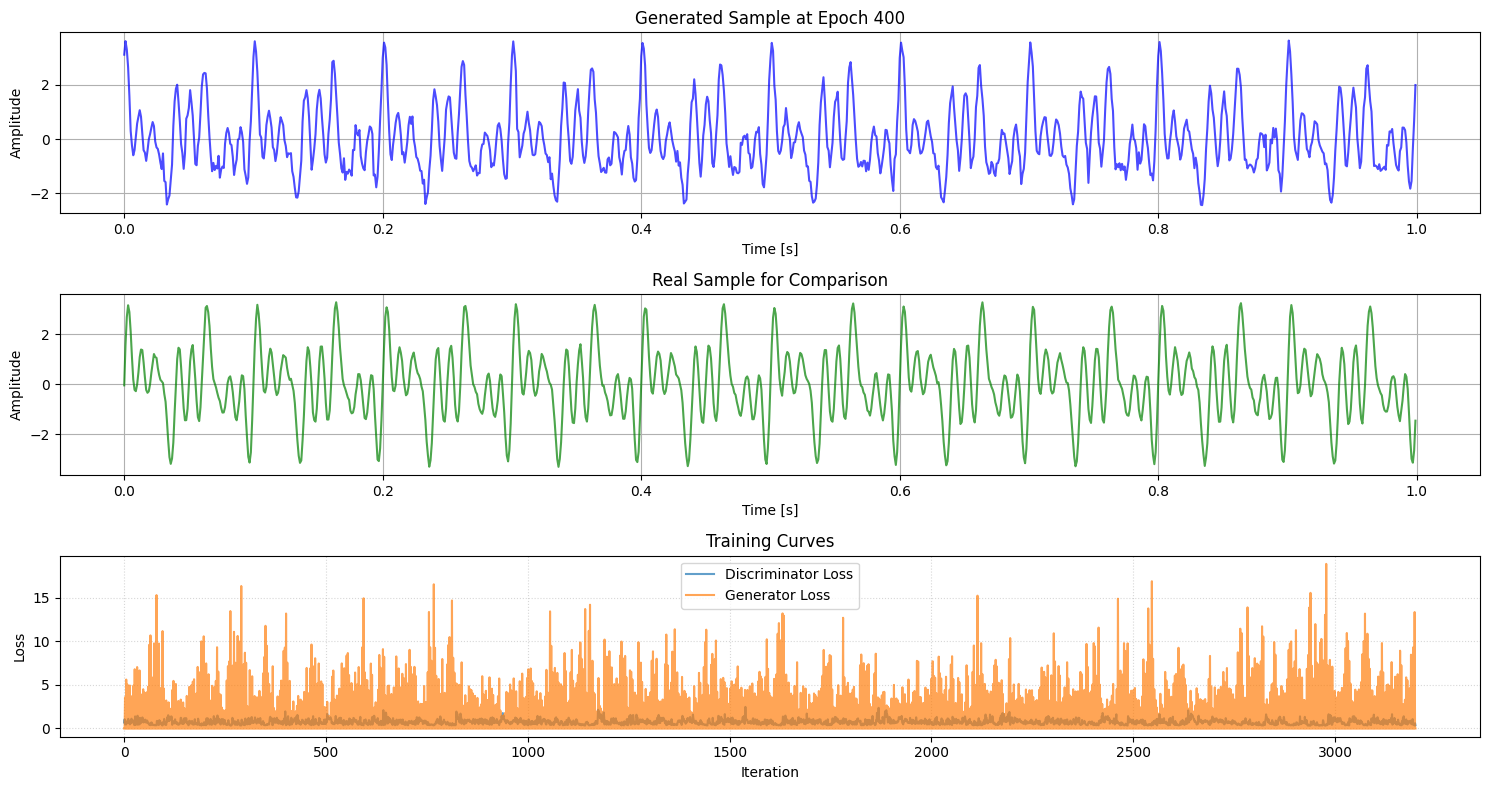

Epoch [450/1000], D Loss: 0.8462, G Loss: 4.3286
Epoch [500/1000], D Loss: 0.6061, G Loss: 0.0000
Epoch [500/1000], D Loss: 0.6061, G Loss: 0.0000


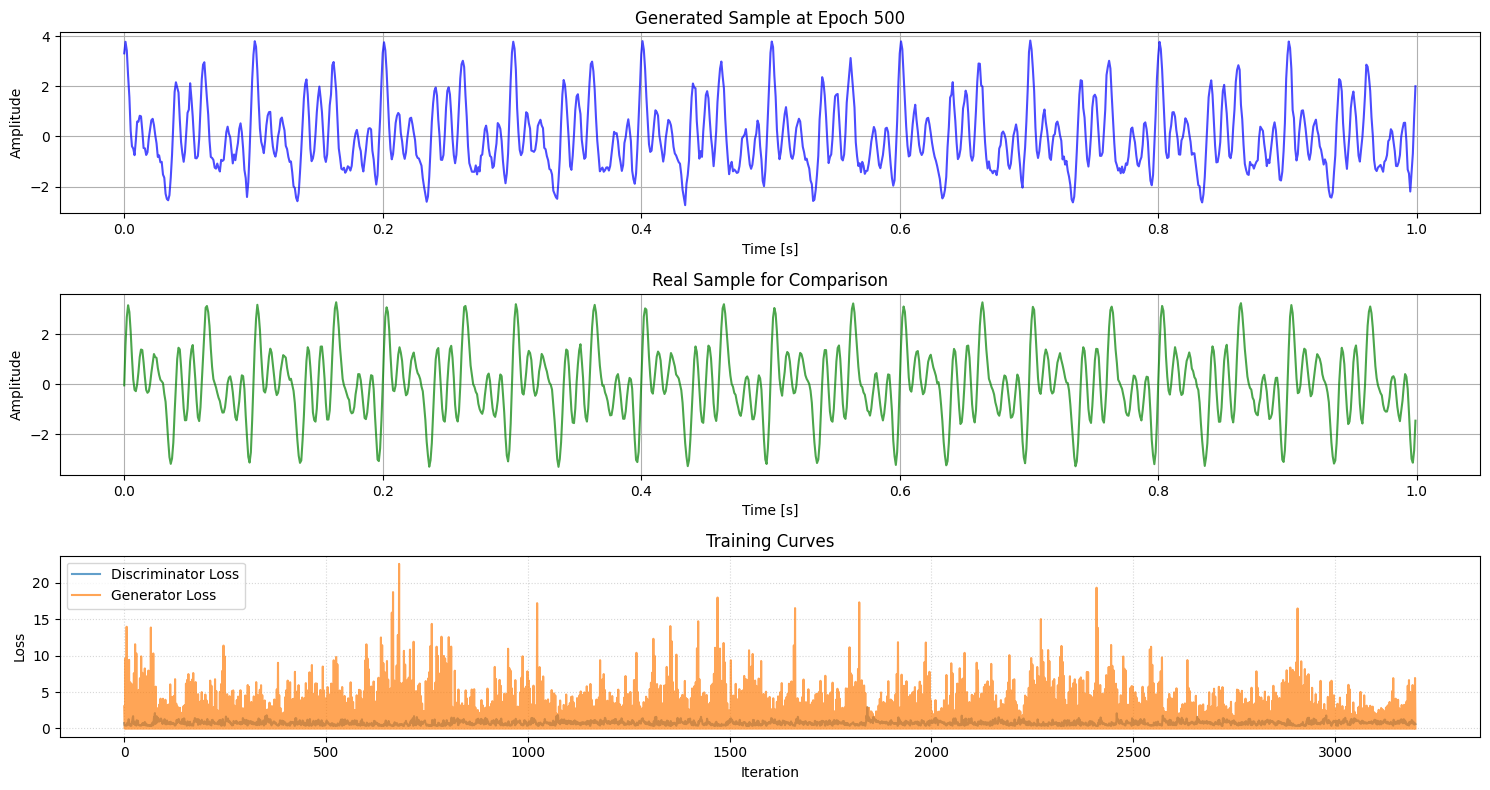

Epoch [550/1000], D Loss: 0.5441, G Loss: 0.0000
Epoch [600/1000], D Loss: 0.6996, G Loss: 7.5324
Epoch [600/1000], D Loss: 0.6996, G Loss: 7.5324


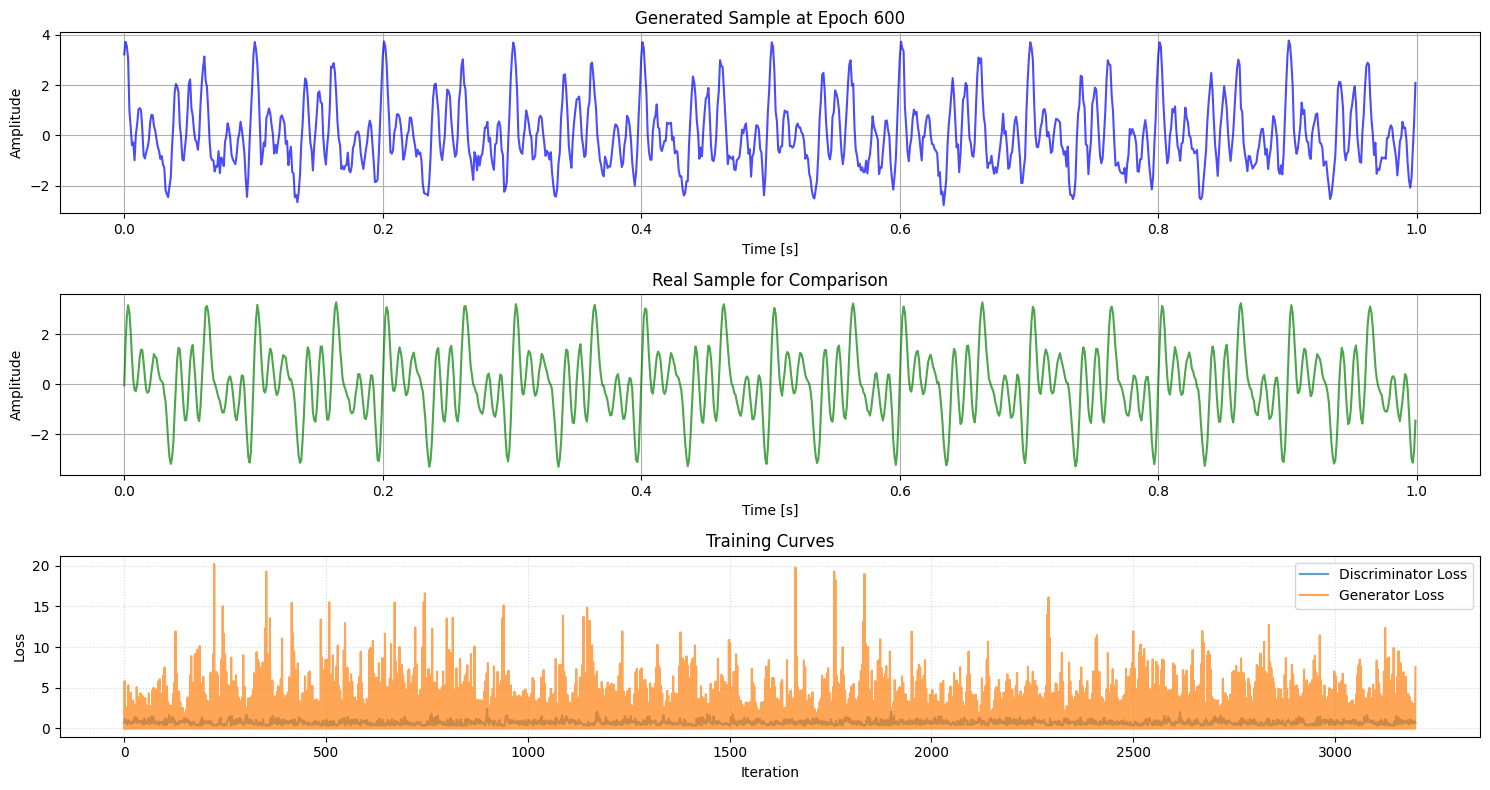

Epoch [650/1000], D Loss: 0.3457, G Loss: 0.0000
Epoch [700/1000], D Loss: 0.6080, G Loss: 0.0000
Epoch [700/1000], D Loss: 0.6080, G Loss: 0.0000


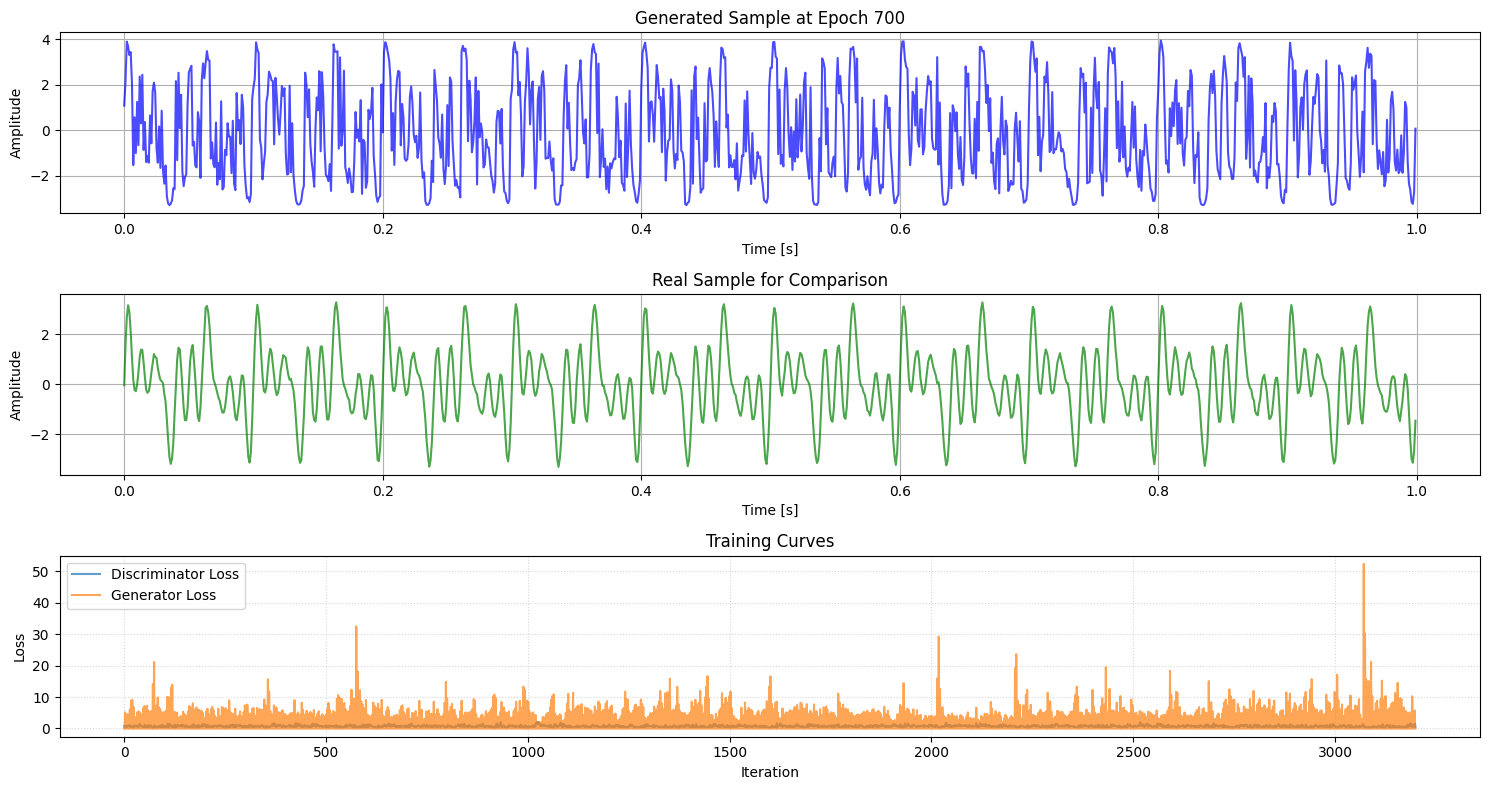

Epoch [750/1000], D Loss: 0.7908, G Loss: 2.9437
Epoch [800/1000], D Loss: 1.1298, G Loss: 0.0000
Epoch [800/1000], D Loss: 1.1298, G Loss: 0.0000


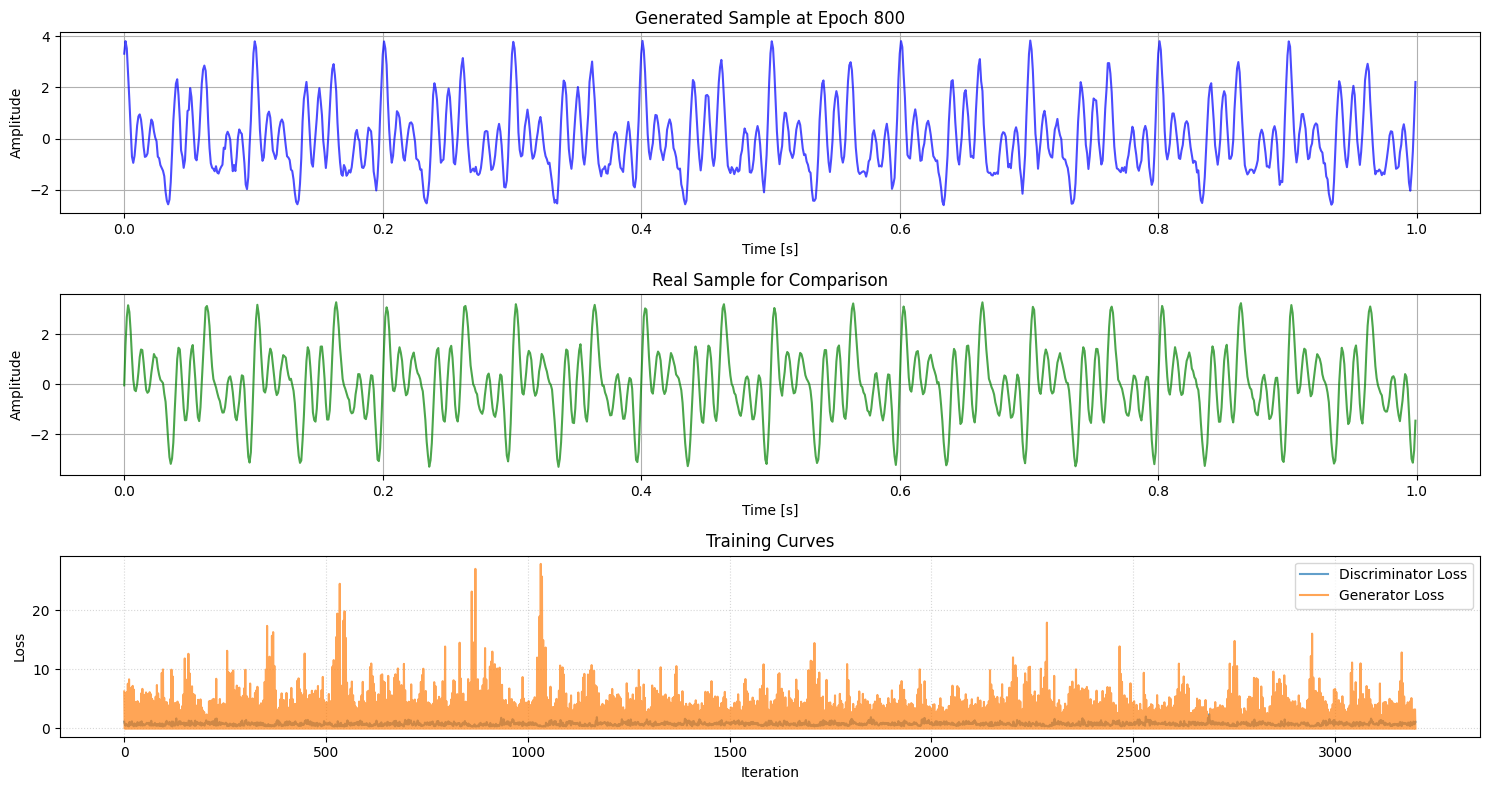

Epoch [850/1000], D Loss: 0.5526, G Loss: 0.0000
Epoch [900/1000], D Loss: 0.6996, G Loss: 7.7839
Epoch [900/1000], D Loss: 0.6996, G Loss: 7.7839


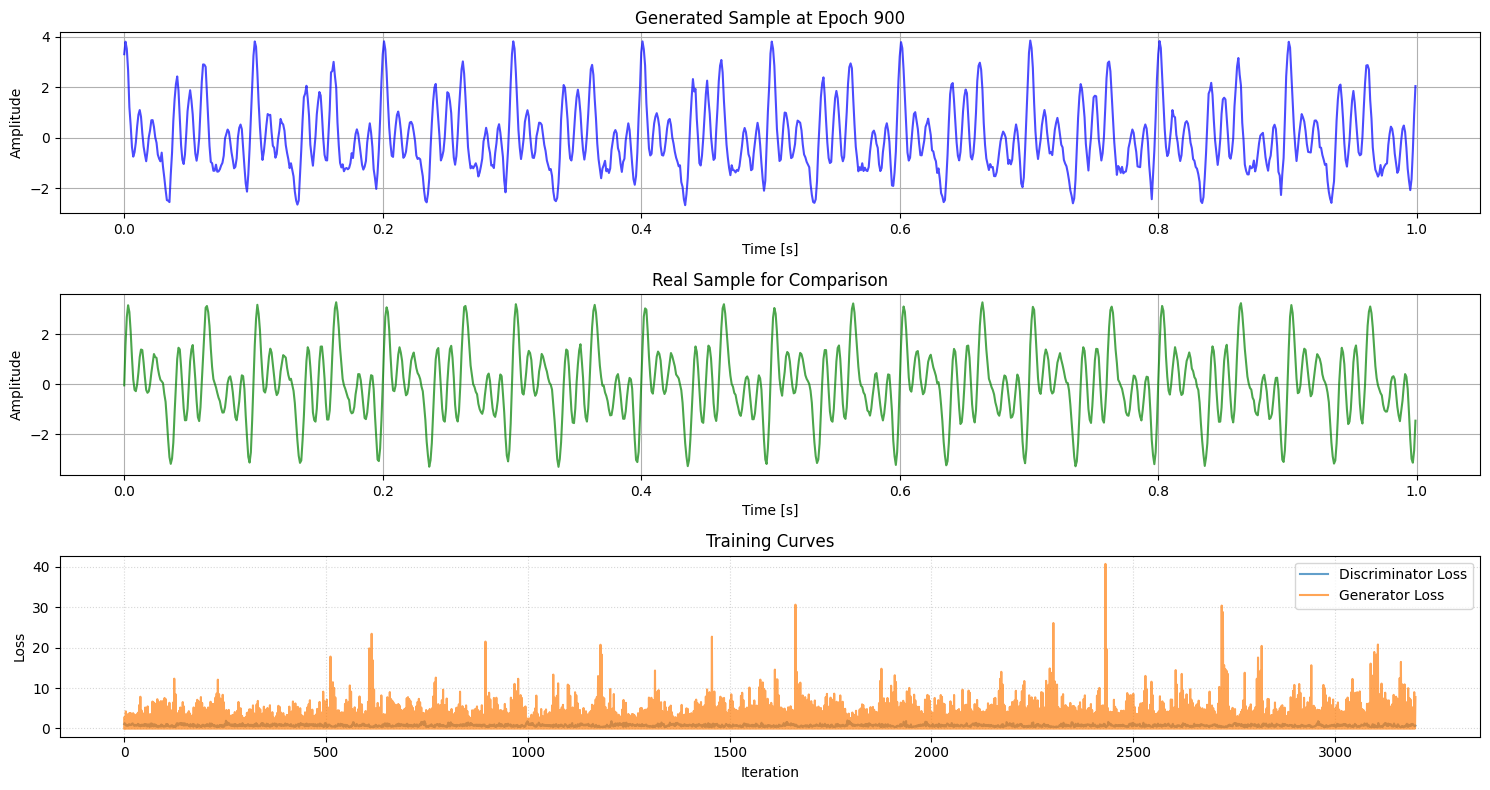

Epoch [950/1000], D Loss: 0.7504, G Loss: 0.0000
Epoch [1000/1000], D Loss: 0.3359, G Loss: 0.0000
Epoch [1000/1000], D Loss: 0.3359, G Loss: 0.0000


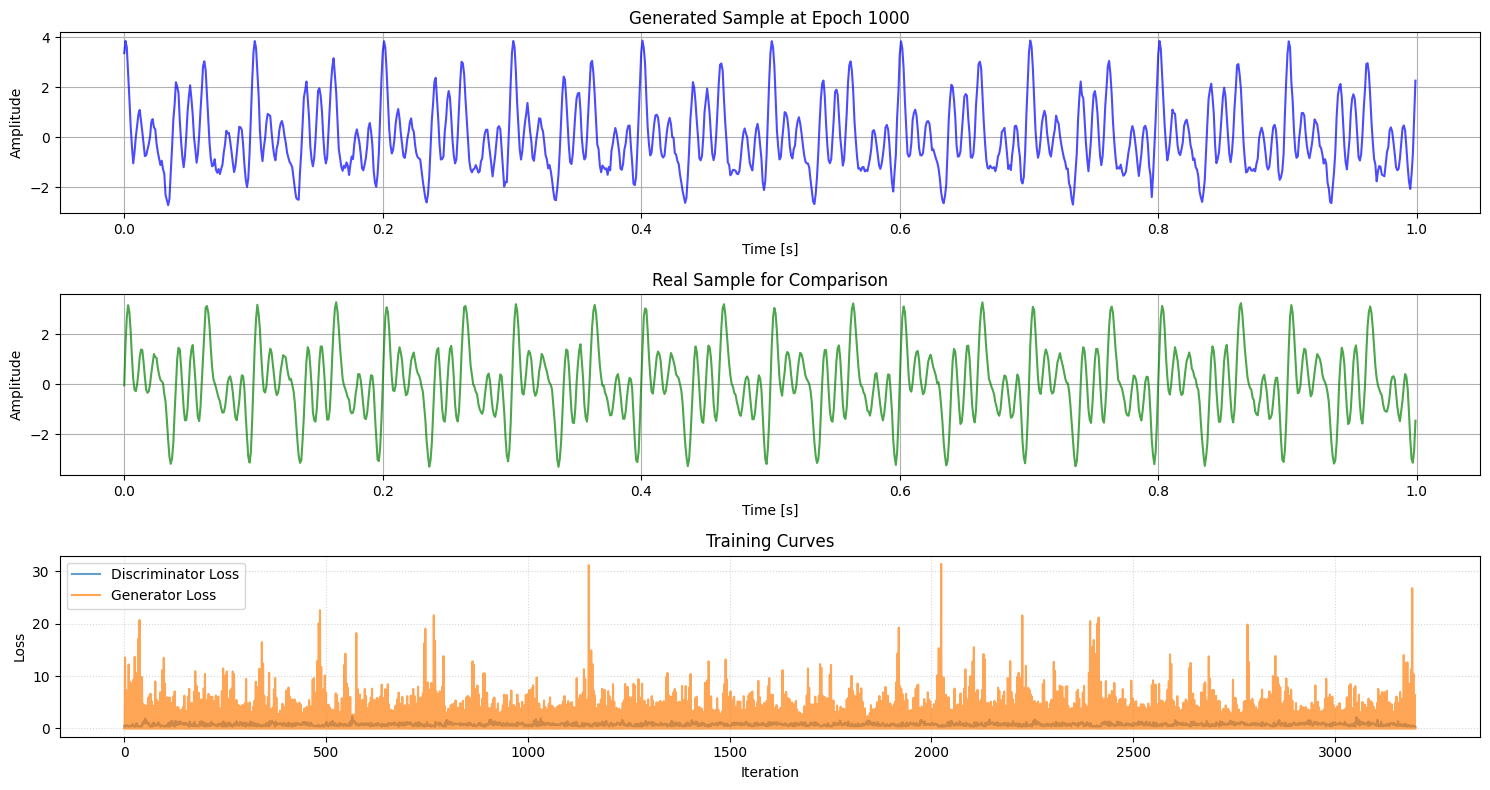

***************** Training finished!!! ****************


In [10]:
global noise_dim
noise_dim = 128  # Aumentado para más variabilidad

class Trainer:
    def __init__(self, generator, discriminator, g_optimizer, d_optimizer, criterion, device, n_critic=3):
        self.generator = generator
        self.discriminator = discriminator
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
        self.criterion = criterion
        self.device = device
        self.n_critic = n_critic  # Entrenar D más veces que G
        self.d_steps = 0

    def train_step(self, real_data):
        batch_size = real_data.size(0)
        real_data = real_data.to(self.device)

        # Train Discriminator (con label smoothing)
        self.d_optimizer.zero_grad()

        # Real data (label smoothing: 0.9 en vez de 1.0)
        real_labels = torch.ones(batch_size, 1).to(self.device) * 0.9
        real_outputs = self.discriminator(real_data)
        d_loss_real = self.criterion(real_outputs, real_labels)

        # Fake data
        noise = torch.randn(batch_size, noise_dim).to(self.device)
        fake_data = self.generator(noise)
        fake_labels = torch.zeros(batch_size, 1).to(self.device)
        fake_outputs = self.discriminator(fake_data.detach())
        d_loss_fake = self.criterion(fake_outputs, fake_labels)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        self.d_optimizer.step()

        self.d_steps += 1

        # Train Generator (solo cada n_critic pasos)
        g_loss = torch.tensor(0.0)
        if self.d_steps % self.n_critic == 0:
            self.g_optimizer.zero_grad()
            noise = torch.randn(batch_size, noise_dim).to(self.device)
            fake_data = self.generator(noise)
            fake_outputs = self.discriminator(fake_data)
            g_loss = self.criterion(fake_outputs, real_labels)  # G quiere que D clasifique como real
            g_loss.backward()
            self.g_optimizer.step()

        return d_loss.item(), g_loss.item()

## Creacion del GAN vanilla mejorado

output_dim = X_dataset_normalized.shape[1]

generator = Generator(noise_dim=noise_dim, output_dim=output_dim).to(device)
discriminator = Discriminator(input_dim=output_dim).to(device)

# Inicializar pesos
generator.apply(weights_init)
discriminator.apply(weights_init)

# Learning rates diferenciados
g_optimizer = Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

criterion = nn.BCEWithLogitsLoss()

trainer = Trainer(generator, discriminator, g_optimizer, d_optimizer, criterion, device, n_critic=3)

num_epochs = 1000  # Aumentado para mejor convergencia
g_errors = []
d_errors = []

EPOCHS_TO_PLOT = 100
LOSS_MAX_VIEW = batch_size * EPOCHS_TO_PLOT

# Usar datos normalizados
dataloader_normalized = get_dataloader(X_dataset_normalized, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs):
    for real_data in dataloader_normalized:
        d_loss, g_loss = trainer.train_step(real_data)
        d_errors.append(d_loss)
        g_errors.append(g_loss)

    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], D Loss: {d_loss:.4f}, G Loss: {g_loss:.4f}')

    if (epoch+1) % EPOCHS_TO_PLOT == 0:
        plt.figure(figsize=(15, 8))
        generator.eval()
        with torch.no_grad():
            noise = torch.randn(1, noise_dim).to(device)
            generated_data = generator(noise).cpu().detach().numpy().reshape(-1)
            # Desnormalizar para comparar con datos originales
            generated_data_denorm = (generated_data + 1) / 2 * (X_max - X_min) + X_min
        generator.train()

        # Subplot 1: Señal generada
        plt.subplot(3, 1, 1)
        plt.plot(Gen_DB_sin_instance.t, generated_data_denorm, color='blue', alpha=0.7)
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.title(f'Generated Sample at Epoch {epoch+1}')
        plt.grid()
        
        # Subplot 2: Señal real (para comparación)
        plt.subplot(3, 1, 2)
        plt.plot(Gen_DB_sin_instance.t, X_dataset[0,:], color='green', alpha=0.7)
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.title('Real Sample for Comparison')
        plt.grid()

        # Subplot 3: Curvas de pérdida
        plt.subplot(3, 1, 3)
        plt.plot(d_errors[max(0, len(d_errors)-LOSS_MAX_VIEW):], label='Discriminator Loss', alpha=0.7)
        plt.plot(g_errors[max(0, len(g_errors)-LOSS_MAX_VIEW):], label='Generator Loss', alpha=0.7)
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.title('Training Curves')
        plt.legend()
        plt.grid(ls=":", alpha=0.5)
        
        plt.tight_layout()
        plt.show()

print("***************** Training finished!!! ****************")

## Test nueva data generada

## Comparación FFT: Real vs Generada

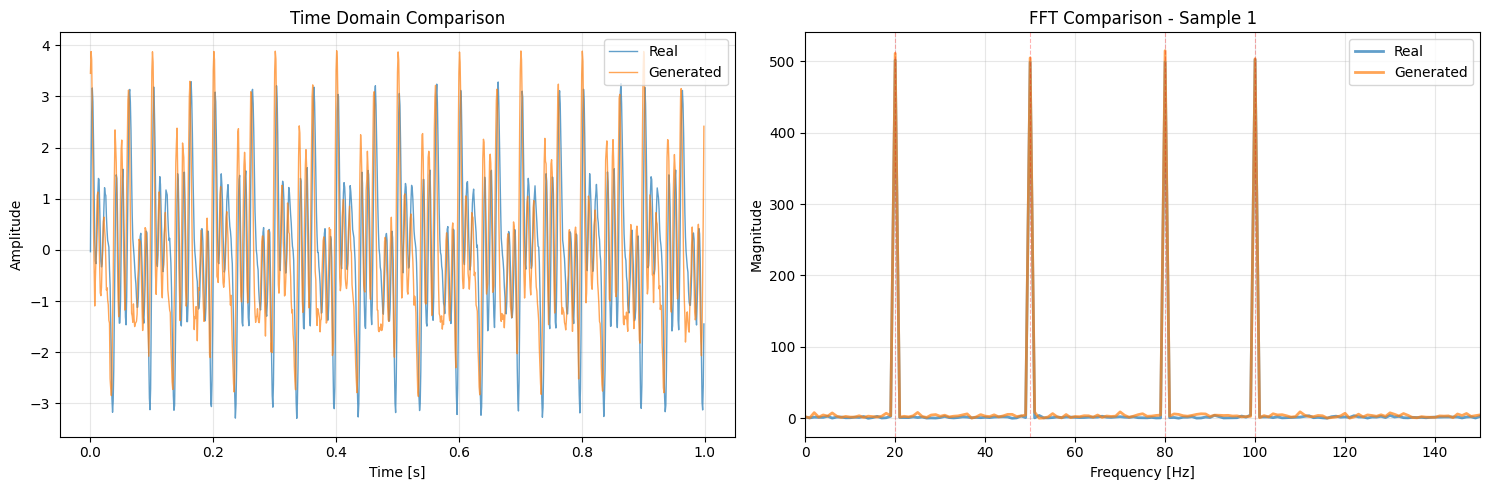

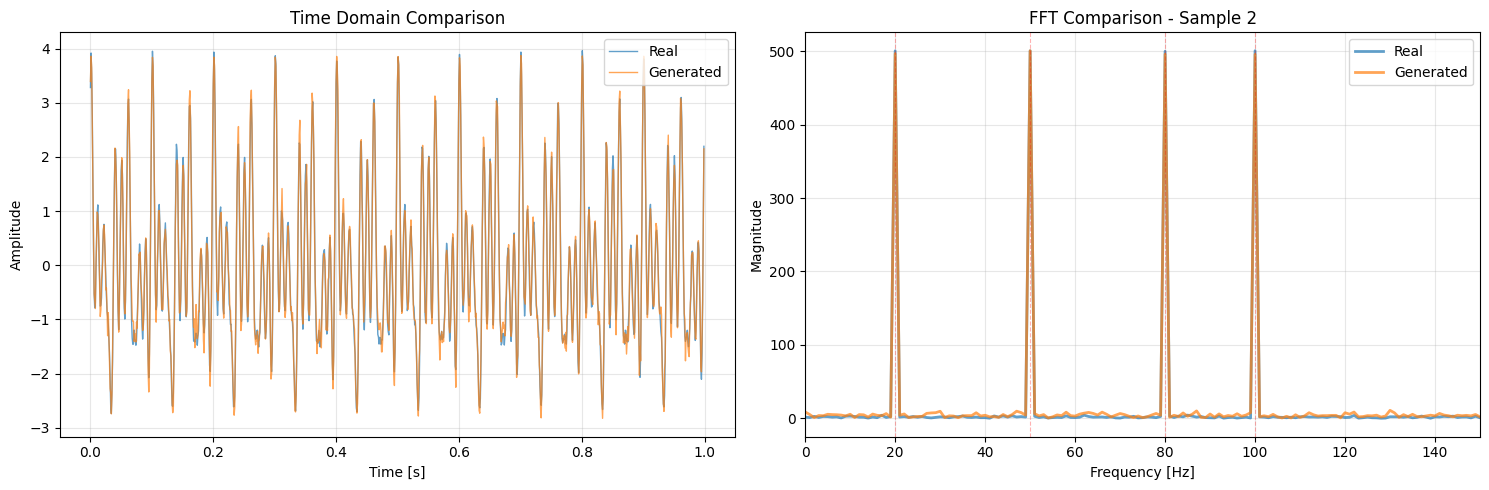

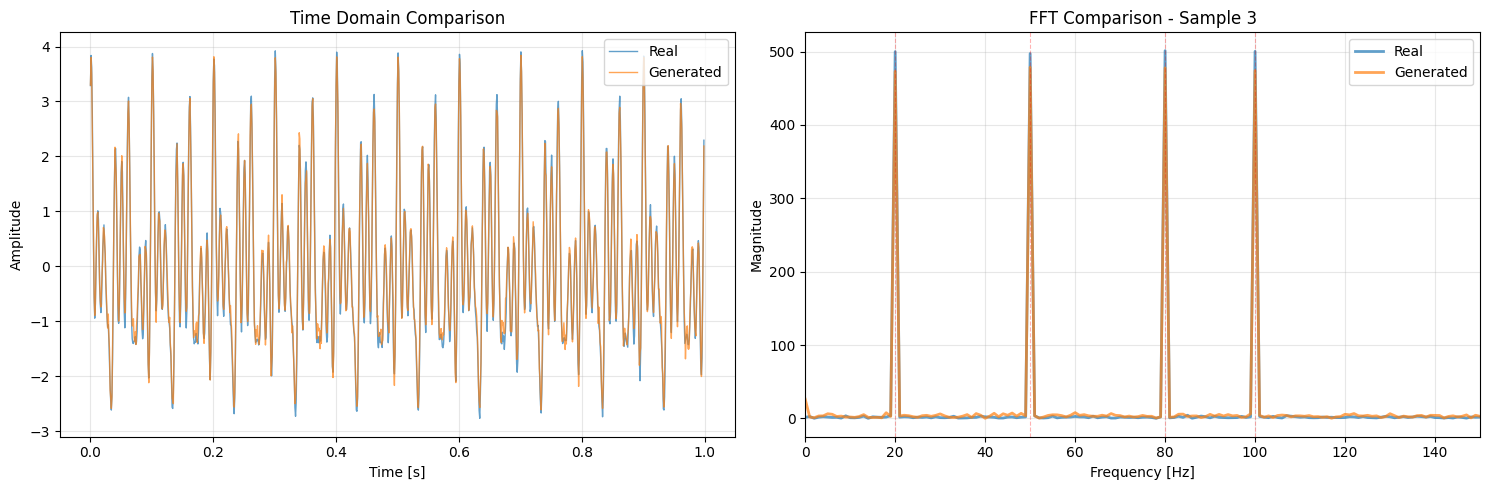

In [14]:
from scipy import signal
from scipy.fft import fft, fftfreq

def plot_fft_comparison(real_signal, generated_signal, fs, title="FFT Comparison"):
    """Compara el espectro de frecuencias de señales reales y generadas"""
    n = len(real_signal)
    
    # FFT de señal real
    fft_real = np.abs(fft(real_signal))
    fft_real = fft_real[:n//2]
    
    # FFT de señal generada
    fft_gen = np.abs(fft(generated_signal))
    fft_gen = fft_gen[:n//2]
    
    # Frecuencias
    freqs = fftfreq(n, 1/fs)[:n//2]
    
    plt.figure(figsize=(15, 5))
    
    # Señales en el tiempo
    plt.subplot(1, 2, 1)
    plt.plot(np.arange(n)/fs, real_signal, label='Real', alpha=0.7, linewidth=1)
    plt.plot(np.arange(n)/fs, generated_signal, label='Generated', alpha=0.7, linewidth=1)
    plt.xlabel('Time [s]')
    plt.ylabel('Amplitude')
    plt.title('Time Domain Comparison')
    plt.legend()
    plt.grid(alpha=0.3)
    
    # Espectros de frecuencia
    plt.subplot(1, 2, 2)
    plt.plot(freqs, fft_real, label='Real', alpha=0.7, linewidth=2)
    plt.plot(freqs, fft_gen, label='Generated', alpha=0.7, linewidth=2)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Magnitude')
    plt.title(title)
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xlim(0, 150)  # Enfocarse en las frecuencias de interés (20, 50, 80, 100 Hz)
    
    # Marcar frecuencias esperadas
    for f in [20, 50, 80, 100]:
        plt.axvline(f, color='red', linestyle='--', alpha=0.3, linewidth=0.8)
    
    plt.tight_layout()
    plt.show()

# Generar múltiples muestras y evaluar
generator.eval()
with torch.no_grad():
    noise = torch.randn(5, noise_dim).to(device)
    generated_samples = generator(noise).cpu().detach().numpy()
    # Desnormalizar
    generated_samples = (generated_samples + 1) / 2 * (X_max - X_min) + X_min

generator.train()

# Comparar con señales reales
for i in range(3):
    plot_fft_comparison(
        X_dataset[i], 
        generated_samples[i], 
        Gen_DB_sin_instance.fs,
        title=f"FFT Comparison - Sample {i+1}"
    )

## Métricas de evaluación adicionales

In [15]:
def evaluate_gan_quality(real_data, generated_data, fs):
    """Calcula métricas de calidad entre señales reales y generadas"""
    from sklearn.metrics import mean_squared_error, mean_absolute_error
    
    # MSE y MAE
    mse = mean_squared_error(real_data, generated_data)
    mae = mean_absolute_error(real_data, generated_data)
    
    # Correlación
    correlation = np.corrcoef(real_data, generated_data)[0, 1]
    
    # Comparación espectral (error en frecuencias dominantes)
    n = len(real_data)
    fft_real = np.abs(fft(real_data))[:n//2]
    fft_gen = np.abs(fft(generated_data))[:n//2]
    spectral_error = mean_squared_error(fft_real, fft_gen)
    
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"Correlation: {correlation:.4f}")
    print(f"Spectral MSE: {spectral_error:.4f}")
    
    return mse, mae, correlation, spectral_error

# Evaluar con múltiples muestras
print("Evaluación de calidad del GAN:")
print("="*50)
generator.eval()
with torch.no_grad():
    noise = torch.randn(100, noise_dim).to(device)
    generated_batch = generator(noise).cpu().detach().numpy()
    generated_batch = (generated_batch + 1) / 2 * (X_max - X_min) + X_min

# Comparar con muestras reales
mse_list, mae_list, corr_list, spec_list = [], [], [], []
for i in range(min(100, len(X_dataset))):
    mse, mae, corr, spec = evaluate_gan_quality(X_dataset[i], generated_batch[i], Gen_DB_sin_instance.fs)
    mse_list.append(mse)
    mae_list.append(mae)
    corr_list.append(corr)
    spec_list.append(spec)

print("\n" + "="*50)
print("Promedios:")
print(f"MSE promedio: {np.mean(mse_list):.4f}")
print(f"MAE promedio: {np.mean(mae_list):.4f}")
print(f"Correlación promedio: {np.mean(corr_list):.4f}")
print(f"Spectral MSE promedio: {np.mean(spec_list):.4f}")
generator.train()

Evaluación de calidad del GAN:
MSE: 1.8095
MAE: 1.0773
Correlation: 0.5368
Spectral MSE: 9.7126
MSE: 0.2108
MAE: 0.3620
Correlation: 0.9524
Spectral MSE: 163.6329
MSE: 0.0229
MAE: 0.1185
Correlation: 0.9944
Spectral MSE: 9.7495
MSE: 0.2453
MAE: 0.3935
Correlation: 0.9402
Spectral MSE: 175.8049
MSE: 0.0210
MAE: 0.1129
Correlation: 0.9950
Spectral MSE: 10.3293
MSE: 0.0235
MAE: 0.1202
Correlation: 0.9948
Spectral MSE: 11.1489
MSE: 0.2255
MAE: 0.3736
Correlation: 0.9479
Spectral MSE: 176.8477
MSE: 0.0228
MAE: 0.1160
Correlation: 0.9945
Spectral MSE: 10.3102
MSE: 6.5798
MAE: 2.3059
Correlation: 0.5380
Spectral MSE: 5924.0885
MSE: 1.8260
MAE: 1.0824
Correlation: 0.5449
Spectral MSE: 11.4690
MSE: 0.0173
MAE: 0.1036
Correlation: 0.9957
Spectral MSE: 6.3046
MSE: 1.8764
MAE: 1.0987
Correlation: 0.5408
Spectral MSE: 7.2601
MSE: 0.4700
MAE: 0.5383
Correlation: 0.9128
Spectral MSE: 403.6004
MSE: 0.0264
MAE: 0.1274
Correlation: 0.9935
Spectral MSE: 12.2977
MSE: 0.0318
MAE: 0.1387
Correlation: 0.9926

Generator(
  (model): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Linear(in_features=256, out_features=512, bias=True)
    (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=512, out_features=1024, bias=True)
    (8): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout(p=0.3, inplace=False)
    (11): Linear(in_features=1024, out_features=1024, bias=True)
    (12): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): LeakyReLU(negative_slope=0.2, inplace=True)
    (14): Linear(in_features=1024, out_features=1000, bias=

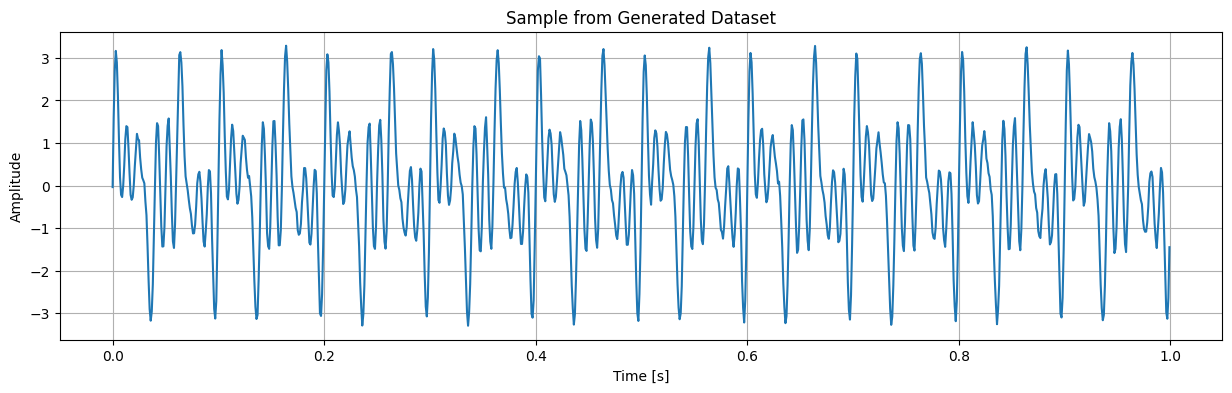

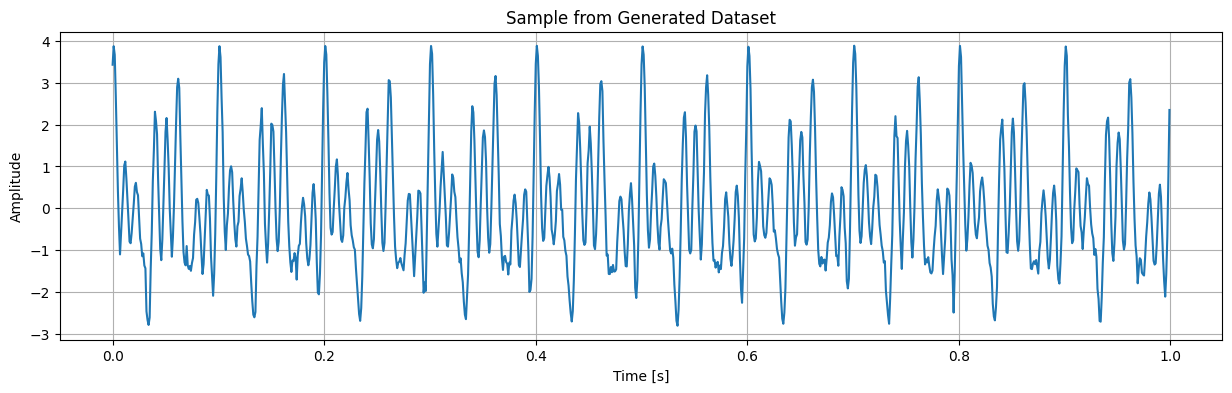

In [16]:
plt.figure(figsize=(15, 4))
plt.plot(Gen_DB_sin_instance.t, X_dataset[0,:])
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Sample from Generated Dataset')
plt.grid()
plt.show()

generator.eval()  # Set to evaluation mode to avoid BatchNorm error
with torch.no_grad():
	noise = torch.randn(1, noise_dim).to(device)
	generated_data2 = generator(noise).cpu().detach().numpy().reshape(-1)
	# Denormalize the generated data
	generated_data2 = (generated_data2 + 1) / 2 * (X_max - X_min) + X_min
generator.train()  # Set back to training mode


plt.figure(figsize=(15, 4))
plt.plot(Gen_DB_sin_instance.t, generated_data2)
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Sample from Generated Dataset')
plt.grid()
plt.show()